# **Assignment 2 - Johan Rytved**
In this assignment i will featurize/encode the molecules in the ESOL dataset using RDKits FingerPrintAsBitVect method, that returns a one-hot-encoded vector, with each bit representing the presence of a certain molecular fragment. I will use these embeddings of the molecules to train a neural network to predict the $log(s)$/solubility of the molecules in the ESOL dataset. To find the best hyperparameters for the model, i will use KerasTuner to perform a search within some reasonable ranges for each hyperparameter.

In the first part i will look at the performance of the model on the train/test/validation sets, and compare to the performance of a null model that simply predicts the mean of the solubilities found in the test-set.

After that i will look at the problem that arises when different molecules with different solubilities, give rise to identical fingerprints, and thus result in identical feature vectors but differing labels. I will also show how the fingerprints are easily compared by calculating Tanimoto similarities.

Then i will go on to show how the error of the predictions made on the test and validation sets, correlate with the distribution of label values (solubilities) that are found in the training set, and discuss how this might affect the effectiveness of evaluating performance on the validation/test set.

Finally i will try to show how the problem of getting identical fingerprints with different molecules can be reduced, by using count-fingerprints, and how featurizing the molecules with count-fingerprints actually gives our model a lower loss on both the training, test and validation set.



#### **Library installation and imports**

In [ ]:
!pip install rdkit keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 13.1 MB/s eta 0:00:00


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import rdkit
from rdkit import Chem, DataStructs, ML
from rdkit.Chem import Draw, AllChem
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from matplotlib import colors
import seaborn as sns
from tqdm import tqdm
import keras_tuner

In [ ]:
soldata = pd.read_csv("https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv")

In [ ]:
sns.set_style("white")

#### **Plotting functions**

In [ ]:
def plot_model_metrics(X_train, X_test, X_val, y_train, y_test, y_val, model, hist, title):

  train_pred, test_pred, val_pred = model.predict(X_train), model.predict(X_test), model.predict(X_val)

  loss = hist.history["loss"]
  val_loss = hist.history["val_loss"]

  tr_loss = np.sqrt(np.mean((y_train - train_pred)**2))
  tst_loss = np.sqrt(np.mean((y_test - test_pred)**2))
  vl_loss = np.sqrt(np.mean((y_val - val_pred)**2))


  fig, ax = plt.subplots(1,4, figsize=(20,5))
  fig.suptitle(title, fontsize=18, fontweight = "bold")
  ax[0].set_title("A. Training and Validation Loss")
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Loss (MSE)")
  ax[0].plot(loss, c="blue", label = "Train Loss")
  ax[0].plot(val_loss, c = "green", label = "Val Loss")
  ax[0].legend()

  ax[1].set_title(f"B. Training Set Predictions vs Truth. RMSE: {tr_loss.round(2)}")
  ax[1].scatter(y_train, train_pred, alpha =.6)
  ax[1].plot(train_pred, train_pred, c = "black")
  ax[1].set_xlabel("$y_{train}$")
  ax[1].set_ylabel("$\hat y_{train}$")

  ax[2].set_title(f"C. Test Set Predictions vs Truth. RMSE: {tst_loss.round(2)}")
  ax[2].scatter(y_test, test_pred, alpha = .6)
  ax[2].plot(test_pred, test_pred,c = "black")
  ax[2].set_xlabel("$y_{test}$")
  ax[2].set_ylabel("$\hat y_{test}$")

  ax[3].set_title(f"D. Validation Set Predictions vs Truth. RMSE: {vl_loss.round(2)}")
  ax[3].scatter(y_val, val_pred, alpha = .6)
  ax[3].plot(val_pred, val_pred, c = "black")
  ax[3].set_xlabel("$y_{test}$")
  ax[3].set_ylabel("$\hat y_{test}$")

  for j in [1,2,3]:
    ax[j].set_xlim(-12,12)
    ax[j].set_ylim(0, -8)

  plt.tight_layout()

In [ ]:
def makefig2():

  labels = dup_subset["Compound ID"].values
  fig, ax = plt.subplot_mosaic("AABC;AADE;AAFG;AAHI;AAJK", constrained_layout=True, figsize = (15,8))

  fig.suptitle("Fig 2. Duplicated Datapoints and associated molecules", fontsize=18, fontweight = "bold")
  ax["A"].scatter(y, full_preds, alpha = .4)
  ax["A"].scatter(dup_subset["measured log solubility in mols per litre"], dup_subset["Predicted Value"], c= "red", label = "Duplicated Predicted Values")
  ax["A"].set_xlabel("$y_{train}$")
  ax["A"].set_ylabel("$\hat y_{train}$")
  ax["A"].set_title("Predicted Values vs Labels for the Full ESOL Dataset")
  ax["A"].legend()

  molaxes = ["B", "C", "D", "E", "F", "G", "H", "I","J", "K"]
  for axis, smiles, label in zip(molaxes, dup_subset.smiles, labels):
    mol = Chem.MolFromSmiles(smiles)
    ax[axis].set_title(smiles)
    ax[axis].imshow(Chem.Draw.MolToImage(mol))
    ax[axis].set_title(f"{label}\n({smiles})")
    ax[axis].axis("off")

  plt.tight_layout()

In [ ]:
def makefig3():
  labels = dup_subset["Compound ID"].values

  N = len(dup_subset)

  fig, ax = plt.subplots(N, 1, figsize = (9,9), sharex=True, sharey=True)

  for i in range(N):
    onbits = duplicated_fps_onbits[i].reshape(1,-1)
    ax[i].imshow(onbits, cmap = "crest")
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_title(labels[i])

    for j in range(onbits.shape[1]):
      ax[i].text(j, 0, onbits[0, j], ha="center", va="center", color="w")

  fig.supxlabel('Indexes of On-Bit')
  fig.suptitle("Fig 3. Comparison of On-Bits of Fingerprints (Duplicated Molecules)", fontweight = "bold", fontsize = 18)
  plt.tight_layout()

In [ ]:
def makefig4():
  l = dup_subset["Compound ID"].values

  fig, ax = plt.subplots(figsize = (15,5))

  ax.imshow(similarity_matrix, cmap = "Greys")

  for i in range(similarity_matrix.shape[0]):
    for j in range(similarity_matrix.shape[1]):
        ax.text(i, j, similarity_matrix[i, j], ha="center", va="center", color="black")

  plt.suptitle("Fig. 4. Tanimoto Similarities of Duplicated Molecules", fontweight = "bold", fontsize = 18)

  ax.set_xticks(range(10))
  ax.set_yticks(range(10))
  ax.set_xticklabels(l, rotation = 90)
  ax.set_yticklabels(l)

  plt.tight_layout()

In [ ]:
def makefig5():
  bitinfos = [{} for i in range(len(dup_subset))]
  mols = [Chem.MolFromSmiles(smiles) for smiles in dup_subset.smiles.values]
  fps = []

  for i in range(len(mols)):
    mol = mols[i]
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, useChirality=True, radius=2, nBits=1024, bitInfo=bitinfos[i], )
    fps.append(fp.GetOnBits())

  tpls = [(mols[0],x,bitinfos[0]) for x in fps[0]]
  Draw.DrawMorganBits(tpls, molsPerRow=4, legends=[str(x) for x in fps[0]])

  fig, ax = plt.subplot_mosaic("PPPPP;ABCDE;FGHIJ;KLMNO", figsize = (8,10))

  ax["P"].imshow(Draw.MolToImage(mols[0]))
  ax["P"].set_title(f"A) {dup_subset['Compound ID'].values[0]}")
  ax["P"].set_xticks([])
  ax["P"].set_yticks([])
  ax["C"].set_title("B) Molecular Fragments for each bit in fingerprint *")

  axis_names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O"]

  for axname, onbit in zip(axis_names, fps[0]):
    ax[axname].imshow(Draw.DrawMorganBit(mols[0],onbit,bitinfos[0]))
    ax[axname].set_xlabel(str(onbit))
    ax[axname].set_xticks([])
    ax[axname].set_yticks([])

  ax["N"].axis("off")
  ax["O"].axis("off")

  fig.suptitle("Fig. 5. 1-Heptanol and the fragments associated with each on-bit in the fingerprint", fontweight = "bold", fontsize = 18)
  fig.supxlabel("* The subscript for each figure showing a bit is the index of the on-bit in the full fingerprint")

In [ ]:
def makefig6():
  fig, ax = plt.subplot_mosaic("AAEEBB;AAEECC;AAEEDD", figsize=(20,7))
  abs_error_test = np.abs(y_test-test_predictions).flatten()
  abs_error_val = np.abs(y_val-val_predictions).flatten()

  ax["A"].set_title("A) Absolute Error vs Predicted Value on Test Set")
  ax["A"].scatter(y_test, abs_error_test, color = "orange")
  ax["A"].set_xlabel("$\hat y_{test}$")
  ax["A"].set_ylabel("Absolute Error")

  ax["A"].set_xlim(-12, 2)
  ax["A"].set_ylim(-1, 8)

  ax["E"].set_title("B) Absolute Error vs Predicted Value on Validation Set")
  ax["E"].scatter(y_val, abs_error_val, color = "green")
  ax["E"].set_xlabel("$\hat y_{test}$")
  ax["E"].set_ylabel("Absolute Error")

  ax["E"].set_xlim(-12, 2)
  ax["E"].set_ylim(-1, 8)

  _, bins, _ = ax["B"].hist(y_train, color = "blue", alpha = 1, label = "Train", bins = 15)
  ax["C"].hist(y_val, color = "green", alpha = 1, label = "Validation", bins = bins)
  ax["D"].hist(y_test, color = "orange", alpha = 1, label = "Test", bins = bins)
  ax["B"].set_title("C) Distribution of Solubility Values in the Different Sets")

  for axis in ["B", "C", "D"]:
    ax[axis].set_xlabel("$y$")
    ax[axis].set_ylabel("Count")
    ax[axis].legend()

  fig.suptitle("Fig. 6. Correlation Between Error and Values of Labels", fontweight = "bold", fontsize = 18)
  fig.tight_layout()

In [ ]:
def makefig7():
  train_rmses = []
  test_rmses = []
  val_rmses = []

  for i in tqdm(range(20)):

    calc_rmse = lambda y, ypred: np.sqrt(np.mean((y-ypred)**2))

    train, test, val, X_train, y_train, X_test, y_test, X_val, y_val = make_train_test_split()
    hist = model.fit(
          X_train,
          y_train,
          validation_data=(X_val, y_val),
          epochs=100,
          batch_size=64,
          callbacks = [early_stop],
          verbose = 0
      )

    train_preds = model.predict(X_train, verbose = 0)
    test_preds = model.predict(X_test, verbose = 0)
    val_preds = model.predict(X_val, verbose = 0)

    train_rmse = calc_rmse(y_train, train_preds)
    test_rmse = calc_rmse(y_test, test_preds)
    val_rmse = calc_rmse(y_val, val_preds)

    train_rmses.append(train_rmse)
    test_rmses.append(test_rmse)
    val_rmses.append(val_rmse)

  fig, ax = plt.subplots(1, figsize = (15,5))
  ax.plot(train_rmses, label = "Train RMSE")
  ax.plot(test_rmses, label = "Test RMSE")
  ax.plot(val_rmses, label = "Validation RMSE")
  ax.legend()
  ax.set_xlabel("Round of train/test/validation splitting")
  ax.set_ylabel("RMSE")
  ax.set_xticks([i for i in range(20)])
  ax.set_xticklabels([i for i in range(20)])

  plt.suptitle("Fig. 7 - Variability in Model Performance Due to Random Data Splitting", fontweight = "bold", fontsize = 18)
  fig.tight_layout()

In [ ]:
def make_table2():
  df = dup_subset
  df = df.style.set_caption("Table 2: SMILES-strings, labels and predicted values for the molecules that have identical predicted values, but differing labels.")
  return df

def make_table1():
  calc_rmse = lambda preds, labels: np.sqrt(np.mean((preds - labels)**2))
  null_rmse = calc_rmse(null_predictions, y)
  train_rmse = calc_rmse(train_predictions, y_train)
  test_rmse = calc_rmse(test_predictions, y_test)
  val_rmse = calc_rmse(val_predictions, y_val)
  std = np.std(y_train)
  df = pd.DataFrame((null_rmse, std, train_rmse, test_rmse, val_rmse), ("Null Model RMSE", "Train Y Standard Deviation.", "Train RMSE", "Test RMSE", "Val. RMSE"), columns = ["Value"])
  df = df.style.set_caption("Table 1: RMSE values for the different models and standard-deviation (Std.) of the labels in the train-set.")
  return df

#### **Encoding molecules as bit-vector fingerprints** + **Train-Test-Validation Splits / Preprocessing**

To encode our molecules as bit-vector fingerprints, we only need the SMILES-string for each molecule in the dataset. The SMILES is converted and rdkit.mol object and then the fingerprint is generated. The fingerprint is lastly converted from an rdkit object to a numpy array, that keras can work with. Below i generate the fingerprints and do a train-test-validation split.

In [ ]:
smiles = soldata.smiles.values
morgan_fp_gen= Chem.rdFingerprintGenerator.GetMorganGenerator(includeChirality=True, radius=2, fpSize=1024, countSimulation = False)
X = np.array([np.array(morgan_fp_gen.GetFingerprint(Chem.MolFromSmiles(smi))) for smi in smiles])
y = soldata["measured log solubility in mols per litre"].values.reshape(-1,1)

Now we have the labels and our features which are the bit-vector fingerprints. Now we can split the data into train, test and validation sets. The reason for the tedious operation of first splitting the entire dataset and then making X and y values, is that we preserve the indexes in the original dataset if we want to fetch the SMILES string or compound ID that gave rise to a specific prediction later on.

In [ ]:
label_col = "measured log solubility in mols per litre"

def make_train_test_split():
  train, test = train_test_split(soldata, test_size=0.2)
  test, val = train_test_split(test, test_size = 0.5)
  X_train, y_train = np.array([np.array(morgan_fp_gen.GetFingerprint(Chem.MolFromSmiles(smi))) for smi in train.smiles]), train[label_col].values.reshape(-1,1)
  X_test, y_test = np.array([np.array(morgan_fp_gen.GetFingerprint(Chem.MolFromSmiles(smi))) for smi in test.smiles]), test[label_col].values.reshape(-1,1)
  X_val, y_val = np.array([np.array(morgan_fp_gen.GetFingerprint(Chem.MolFromSmiles(smi))) for smi in val.smiles]), val[label_col].values.reshape(-1,1)

  return train, test, val, X_train, y_train, X_test, y_test, X_val, y_val

train, test, val, X_train, y_train, X_test, y_test, X_val, y_val = make_train_test_split()

#### **Neural Network Model**


##### **Training the Model**

In my model I've implemented an architecture of 3 dense layers with a decreasing number of nodes all utilizing the ReLU activation function. The layers are interspersed by batch normalization layers. There is a dropout layer with a large dropout rate before the output to combat overfitting. The model uses early stopping (conditioned on the validation set) as well as a learning rate decaying scheme, where the weights decay by a factor of 0.96 for every 1000 steps.

In [ ]:
feature_dim = X_train.shape[1]

model = keras.models.Sequential([
    keras.layers.Dense(228, activation=keras.activations.relu, input_shape=(feature_dim,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(144, activation=keras.activations.relu),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(88, activation=keras.activations.relu),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.7),
    keras.layers.Dense(1),
])

In [ ]:
initial_learning_rate = 0.01
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=32500, decay_rate=0.94, staircase=True)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 15)

model.compile(
  optimizer=opt,
  loss='mean_squared_error'
)

In [ ]:
split_hist = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=64,
        callbacks = [early_stop],
        verbose = 0
)

##### **Hyperparameter Tuning with KerasTurner**
In this assignment i've chosen to user KerasTuner to do the hyperparameter tuning, rather than adjusting hyperparameters myself. Below i do a search to find (some) of the best hyperparameters for our model. KerasTuner let's you define a search space of some hyperparameters in a given range. I choose to search for the best number of nodes in the layers, the best dropout rate and the best learning rate. The model is at each evaluation step tested for it's performance against the validation set and the loss saved. Whatever hyperaparameters that give the best performance on the validation set are saved!

Using the KerasTuner is pretty easy, because all we have to do is build the model inside a function, and for all hyperparameters we want to tune we pass a speciel kerastuner variable (hp.Int, hp.Float) that have a min_value, max_value and a step. We then do a search over that search space. How the search is carried out depends on the tuner you chose. I tried the RandomSearch tuner first, but had better success with the BayesianOptimization tuner. **I chose to do 100 trials which will take a long time, so don't run the cells below again, if you don't wait to wait for a good 20 minutes :)**

In [ ]:
def build_model(hp):

  model = keras.models.Sequential([
    keras.layers.Dense(hp.Int("l1_units", min_value=64, max_value=256, step=4), activation=keras.activations.relu, input_shape=(feature_dim,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(hp.Int("l2_units", min_value=16, max_value=192, step=4), activation=keras.activations.relu),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(hp.Int("l3_units", min_value=8, max_value=128, step=4), activation=keras.activations.relu),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(hp.Float("dropout_rate", min_value=0.7, max_value=0.98, step = 0.1)),
    keras.layers.Dense(1),
  ])

  initial_learning_rate = hp.Float("lr", min_value=0.01, max_value=0.08, step = 0.005)

  lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=hp.Int("dc_steps", min_value=500, max_value=50000, step=500), decay_rate=hp.Float("decay_rate", min_value=0.9, max_value=0.99, step = 0.01), staircase=True)

  opt = keras.optimizers.Adam(learning_rate=lr_schedule)
  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 15)

  model.compile(
    optimizer=opt,
    loss='mean_squared_error'
  )

  return model

In [ ]:
build_model(keras_tuner.HyperParameters())

In [ ]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=100,
    alpha=0.0001,
    beta=2.6,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="assigment2_hyperparameter_search",
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
l1_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 4, 'sampling': 'linear'}
l2_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 192, 'step': 4, 'sampling': 'linear'}
l3_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 4, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.7, 'conditions': [], 'min_value': 0.7, 'max_value': 0.98, 'step': 0.1, 'sampling': 'linear'}
lr (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.01, 'max_value': 0.08, 'step': 0.005, 'sampling': 'linear'}
dc_steps (Int)
{'default': None, 'conditions': [], 'min_value': 500, 'max_value': 50000, 'step': 500, 'sampling': 'linear'}
decay_rate (Float)
{'default': 0.9, 'conditions': [], 'min_value': 0.9, 'max_value': 0.99, 'step': 0.01, 'sampling': 'linear'}


In [ ]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Trial 100 Complete [00h 00m 17s]
val_loss: 2.5713971853256226

Best val_loss So Far: 1.4499304294586182
Total elapsed time: 00h 22m 26s


Below we see that for the 100 trials run, this should be the best hyperparameters!

In [ ]:
tuner.get_best_hyperparameters()[0].values

{'l1_units': 128,
 'l2_units': 192,
 'l3_units': 128,
 'dropout_rate': 0.7,
 'lr': 0.01,
 'dc_steps': 30500,
 'decay_rate': 0.91}

#### **Plot of Model Metrics**

In **Fig. 1** I've plotted:

**A:** The training and validation loss  over epochs. The losses follow each other nicely, so at least we can see there is not a very heavy case of overfitting, where we would see that the loss keeps going down on the training set, but starts to increase on the validation set.

**B:** Predictions on the training set vs truth (labels). The predicctions fit pretty nicely. The black line is the identity line ($y$ vs $y$) that represents 'perfect' predictions. We see that the predictions seem to get slightly worse for very high and very low solubility values.

**C:** Predictions on the test set. RMSE is slightly higher than for the training set. The model is a bit overfit to the training data, but it's not too bad.

**D:** Predictions on the validation set. RMSE is slightly higher than on the test set. This is likely due to random train test splitting, and how the distribution of solubility values in the validation set matches the distribution in the training data. I will get back to that later.



4/4 [==============================] - 0s 4ms/step


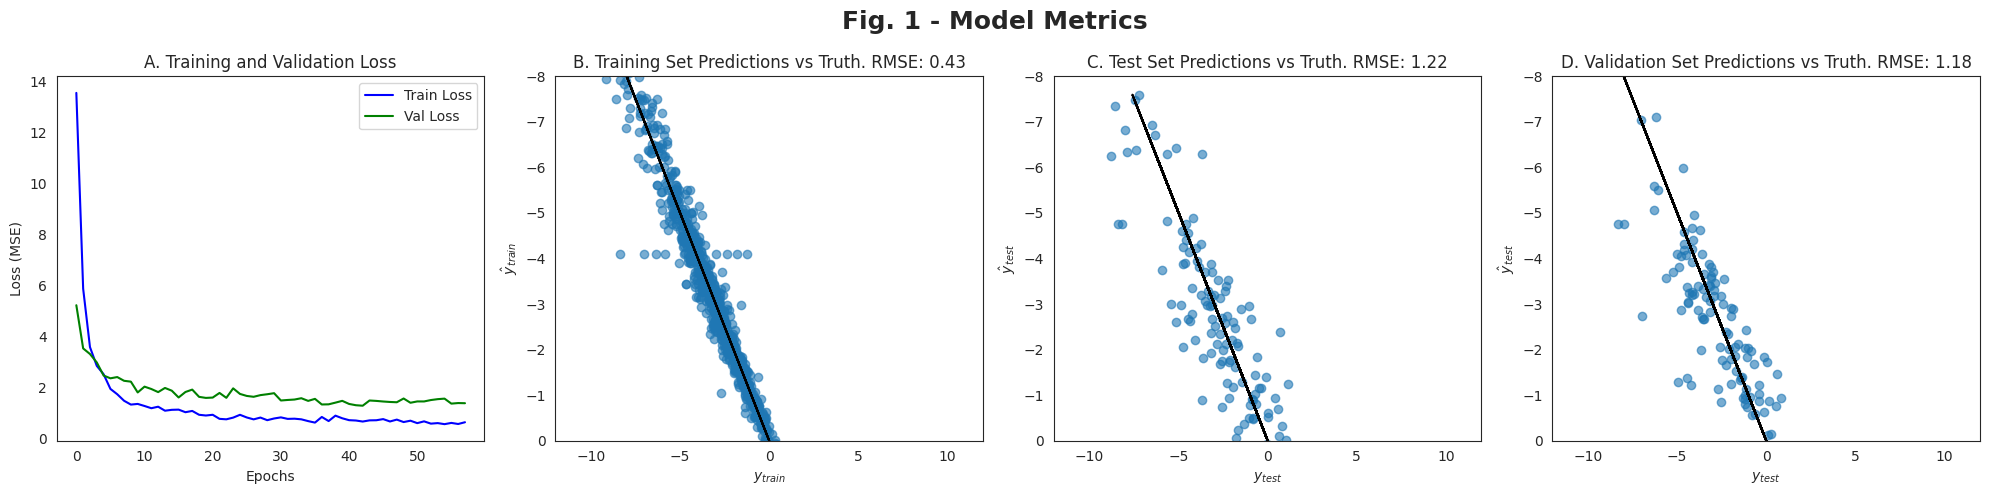

In [ ]:
plot_model_metrics(X_train, X_test, X_val, y_train, y_test, y_val, model = model, hist = split_hist, title = "Fig. 1 - Model Metrics")

#### **Comparison of Neural Net Predictions with a Null-Model**
To examine how well our model is actually working, we wil compare it with a naive model, that simply predicts the mean log(s) for all our molecules. Below i save the predictions made on the test and train set, as well as the null predictions. The null prediction is just a vector of length $\vert y \vert$ where each elements value is the mean, $\bar x$ of the labels.

In [ ]:
mean_logs = y.mean()
null_predictions = [mean_logs for i in range(len(y))]
test_predictions = model.predict(X_test)
val_predictions = model.predict(X_val)
train_predictions = model.predict(X_train)
full_preds = model.predict(X)

36/36 [==============================] - 0s 2ms/step


In [ ]:
make_table1()

,Value
Null Model RMSE,2.095512
Train Y Standard Deviation.,2.051027
Train RMSE,0.429583
Test RMSE,1.216675
Val. RMSE,1.176338


Looking at the table above, we can luckily see that the neural performs quite a lot better on the test and train set, than the null-model that simply predicts the mean does. We can also see that the RMSE for the null-model is practically equal to the standard deviation of the labels, which makes sense because it exactly is the measure of how much the values deviate from the mean on average.

So if our models RMSE is not significantly lower than the standard deviation, then our models predictions are not any better than just predicting the mean for the labels in question. And a model could thus achieve a similar loss by just 'learning' to predict the mean for all labels. In that case the models predictions are not meaningful in anyway, as they are not actually based on a relationship between the features put into the model.

#### **Examining Duplicated Predicted Solubility Values**

In plot B of Fig. 1, we can see that there is a series of datapoints with identical predicted values but very different labels. Below i will create a dataframe that contains the labels and predictions for the test-set as well as the SMILES-strings representing the molecules, that we saved earlier. I will use the pandas .duplicated() method to subset the dataframe for duplicate value, and then further subset for those duplicates that are around the values visible in the plot to find the points in the plot that we are interested in. For ease of locating these earlier on i've hardcoded the indexes of the duplicated molecules in the variable dup_indexes.

In [ ]:
# I used the below code to identify the duplicated molecules, but due to the random nature of the train-test splitting as well as random initialization of the weights,
# it's not guaranteed that these molecules will appear if we run the model again. So i just saved their indexes in the original dataframe for the future plotting purposes-
#dup_subset = test_df[(test_df.Prediction.duplicated(keep = False)) & (test_df.Prediction < -4.5) & (test_df.Prediction > -5)]
dup_indexes = [25, 152, 316, 435, 613, 783, 788, 924, 969, 1062]
dup_subset = soldata.loc[dup_indexes][["Compound ID", "smiles", "measured log solubility in mols per litre"]]
dup_subset["Predicted Value"] = full_preds[dup_indexes]

In [ ]:
make_table2()

,Compound ID,smiles,measured log solubility in mols per litre,Predicted Value
25,1-Heptanol,CCCCCCCO,-1.810000,-4.100942
152,1-Hexanol,CCCCCCO,-1.240000,-4.100942
316,1-Hexadecanol,CCCCCCCCCCCCCCCCO,-7.000000,-4.100942
435,1-Octanol,CCCCCCCCO,-2.390000,-4.100942
613,1-Nonanol,CCCCCCCCCO,-3.010000,-4.100942
783,1-Tetradecanol,CCCCCCCCCCCCCCO,-5.840000,-4.100942
788,1-Octadecanol,CCCCCCCCCCCCCCCCCCO,-8.400000,-4.100942
924,1-Dodecanol,CCCCCCCCCCCCO,-4.800000,-4.100942
969,1-Pentadecanol,CCCCCCCCCCCCCCCO,-6.350000,-4.100942
1062,1-Decanol,CCCCCCCCCCO,-3.630000,-4.100942


Just to confirm that it is the correct datapoints that i've identified, i will do the plot again and color the datapoints in question, in Fig. 2. I'll also include the molecular structures of the molecules in question.

<ipython-input-6-85fa189305ea>:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


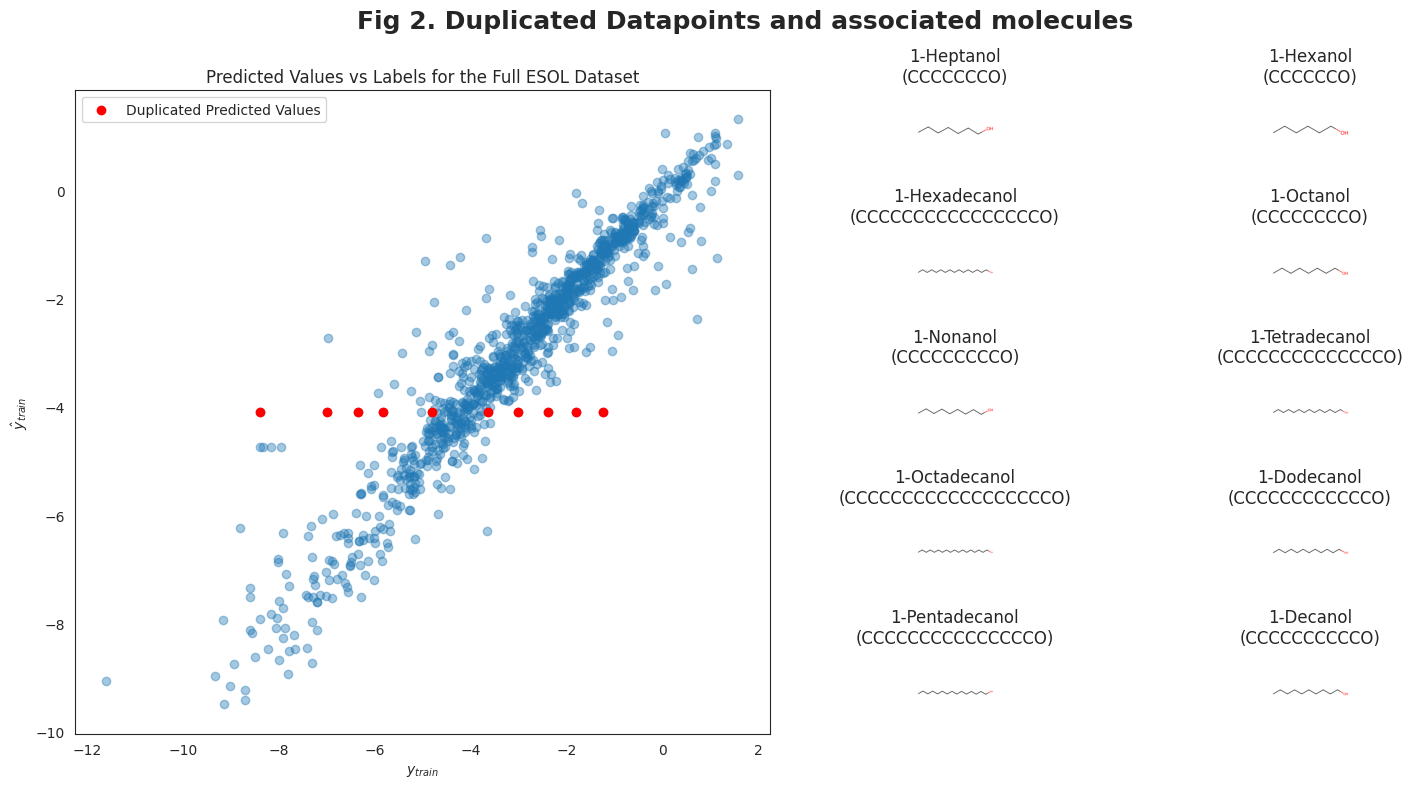

In [ ]:
makefig2()

In Fig. 2 i have identified duplicated predicted values, that differ quite a bit in their actual solubilities. Next i will generate their fingerprints, which should explain why their predicted values are identical.

#### **Comparison of ECFP fingerprints for the duplicated molecules**
Below i will use the generator i also used previously, to get the fingerprints for the duplicated molecules. I'll try to compare their similarities, both with their tanimoto similarity, comparing their entire fingerprints and comparing the on-bits of their fingerprints.

In [ ]:
duplicated_fps = [morgan_fp_gen.GetFingerprint(Chem.MolFromSmiles(smi)) for smi in dup_subset.smiles]
duplicated_fps_onbits = [np.array(fp.GetOnBits()) for fp in duplicated_fps]
duplicated_fps_reshaped = [np.array(i).reshape(32,32) for i in duplicated_fps]

Looking in figure 3. we can quickly realize that all the fingerprints are identical, even though the molecules are different. In **Fig. 3** i have plotted only the bits that are on in the fingerprints (retrieved wih fp.GetOnbits()) and their indexes as the value that is written in each cell. The bits that are on, are just the nonzero-bits from the full fingerprint vectors. The color of each cell  reflects the index of the bit. First of all we can see that the molecules all have the same amount of bits. And we can also see that the indexes of all the bits are the same. So in other words, the fingerprints are one hundred percent identical!

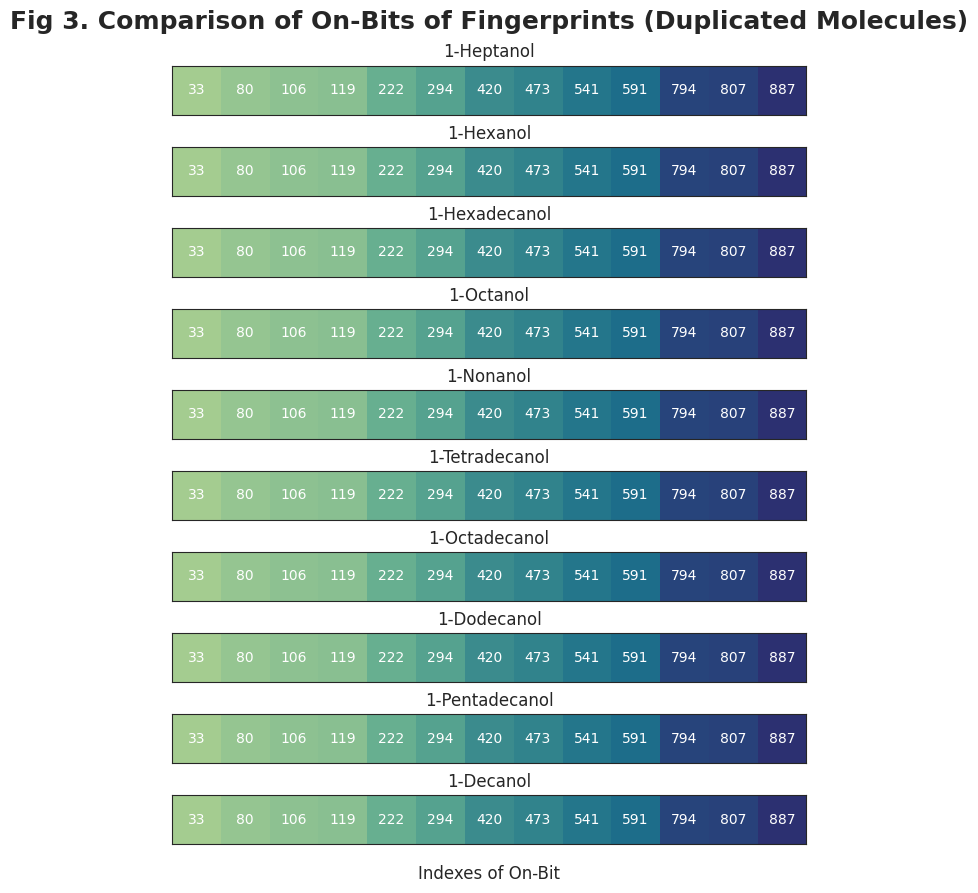

In [ ]:
makefig3()

#### **Comparison of fingerprints using tanimoto similarities**

Another way to show fingerprint similarity is using the molecules tanimoto similarity, which is based on the similarity between two fingerprints. The Tanimoto similarity is a measure of how many of the bits that are shared between the two molecules, as compared to the total amount of bits present in the two. In other words, it is the ratio of the intersection of A and B to the union of A and B, with A and B being the fingerprint of the two molecules.

$$T(A,B) = \frac{\vert A \cap B\vert}{\vert A \cup B \vert}= \frac{\vert A \cap B\vert}{\vert A \vert + \vert B \vert - \vert A \cap B \vert}$$

Below i will do a loop that calculates the pairwise tanimoto similarities for all the duplicated molecules. And we should see the same result, that their similarities are 1!

In [ ]:
N = len(duplicated_fps)
similarity_matrix = np.zeros((N,N))
for i in range(N):
  for j in range(N):
    sim = DataStructs.TanimotoSimilarity(duplicated_fps[i],duplicated_fps[j])
    similarity_matrix[i][j] = sim

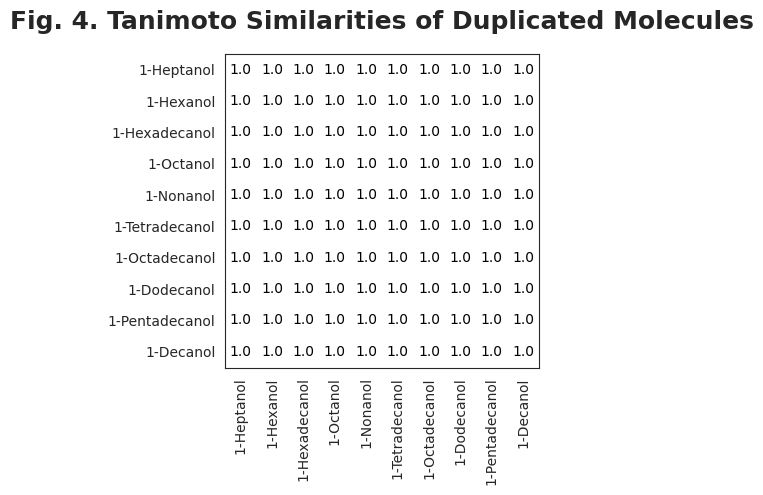

In [ ]:
makefig4()

Just as thought the pairwise Tanimoto similarities are all 1 for the duplicated molecules.

#### **Why are the fingerprints identical for molecules that are not identical?**
The above result raises the question of why the fingerprints are identical, if the molecules are not. This is not great for our model, that we are supplying identical features, but differing labels, because then we are forcing the model to make different predictions based on the same features. Below i have plotted the molecular features that trigger each bit for the first of the identified duplicate molecules. Since all fingerprints are identicals, as i showed in Fig. 4, this should be representative of the fingerprints of all the duplicated molecules.

Since the bits of our fingerprints are triggered by the presence of a certain fragment only, it doesn't take into account how often that fragment occurs. We saw back in Fig. 2 that the duplicate molecules are all fatty alcohols of varying length. Here in Fig. 5 we see the fragments that constitute the fingerprint. All the fragments are shared by all the fatty alcohols, regardless of the length of the carbon chain. So without taking into account how many times a certain feature appears, such as how many times we see a carbon bonded to a carbon bonded to a carbon (*see the fragment for the bit with index 119*), there is no way that the fingerprints can discern between these different fatty alcohols.

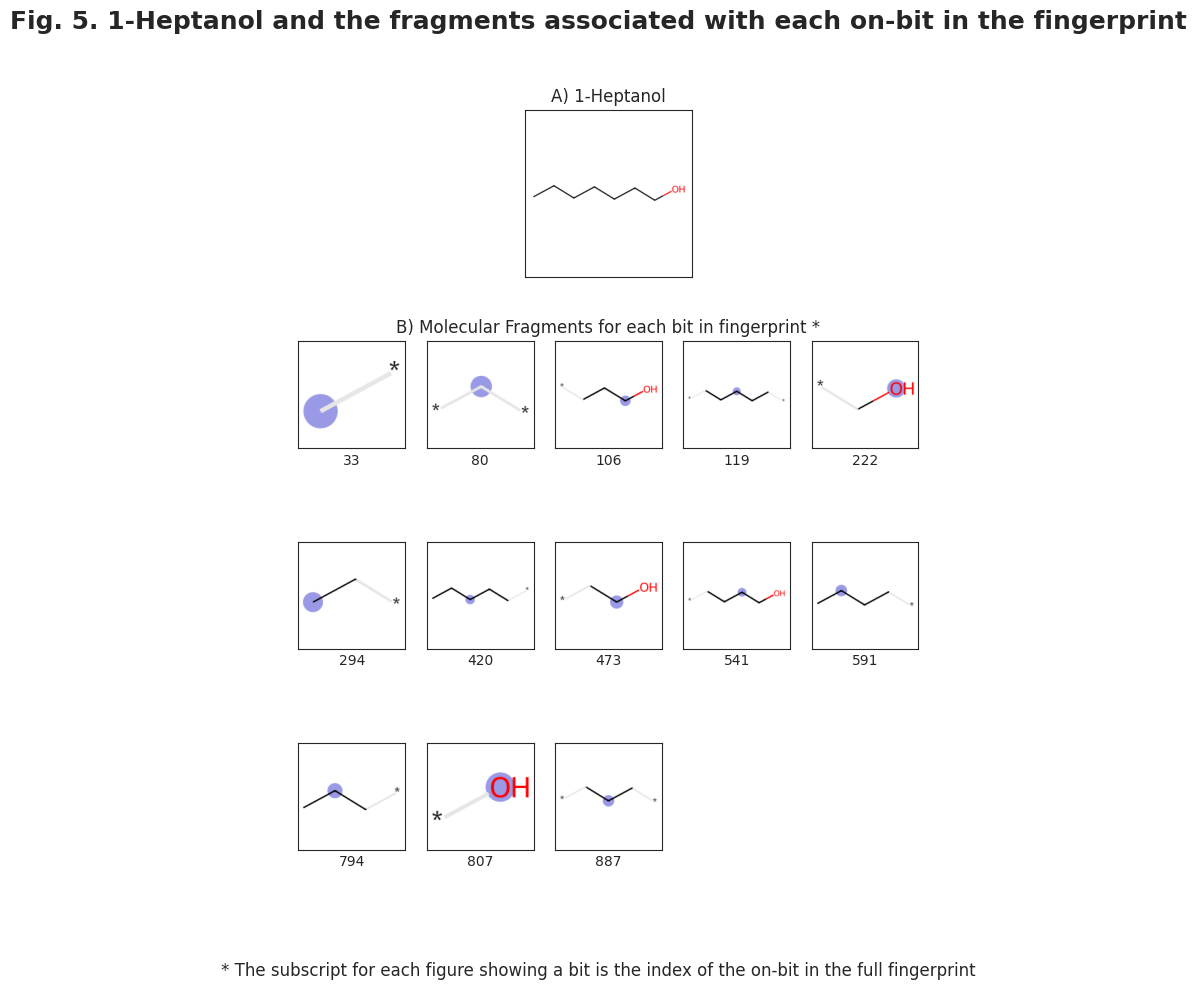

In [ ]:
makefig5()

So in figure 5. it's apparent that the default way to create fingerprints has some limitations. We see that when using the default settings for the fingerprint generator, there is not enough features picked up to discern between hydroxylated alkanes of varying length.

#### **Correlation Between Error and Solubility**
Below in figure **6.A** and **6.B** i have plotted the absolute error on the test set against the predicted value made on the test-set and validation set. In figure **6.C** i have plotted the distribution of the solubility values in the train, test and validation set.

It is clear that the error of the predictions made on the test-set reflects the distribution of the solubility values in training set. The values that have few training instances (molecules with a very high or very low solubility) are also those that end up having large errors when predicting on the test set. So the figure reflects the fact, that the model is the best at predicting on molecules that resemble the ones it has seen during training. The same goes for the validation set.

So what this goes to show is that the way we split the data ultimately affects the way we evaluate  our model, and also that the metrics we obtain when using data from our validation and test sets, highly depend on how those values were selected.

In this case the validation set is missing a lot of very soluble molecules. So we are not really testing our model in the range were it might be harder for the model to make a prediction, due to the skewed distribution of the full dataset. And that's not very good, because then we are overestimating our models ability. We can also see that the validation set probably resembles the distribution of the train set better. But actually it even seems like the training set has even fewer very insoluble molecules, than the validation set.

On the other hand, we could have made a train-test-validation split, where the validation set had fewer molecules with a solubility around the mean, and many that were in the very high or very low values. In that case we would be testing the model mainly on molecules that don't represent the full data very well, and we would think that the model is far worse than it really is.

So in conclusion, it is important that the train, test and validation sets have similar distributions of solubility values, such that we are testing the model on the same 'kind' of data as what we are training it on. Otherwise we might come to the wrong conclusions about how good the model really is.


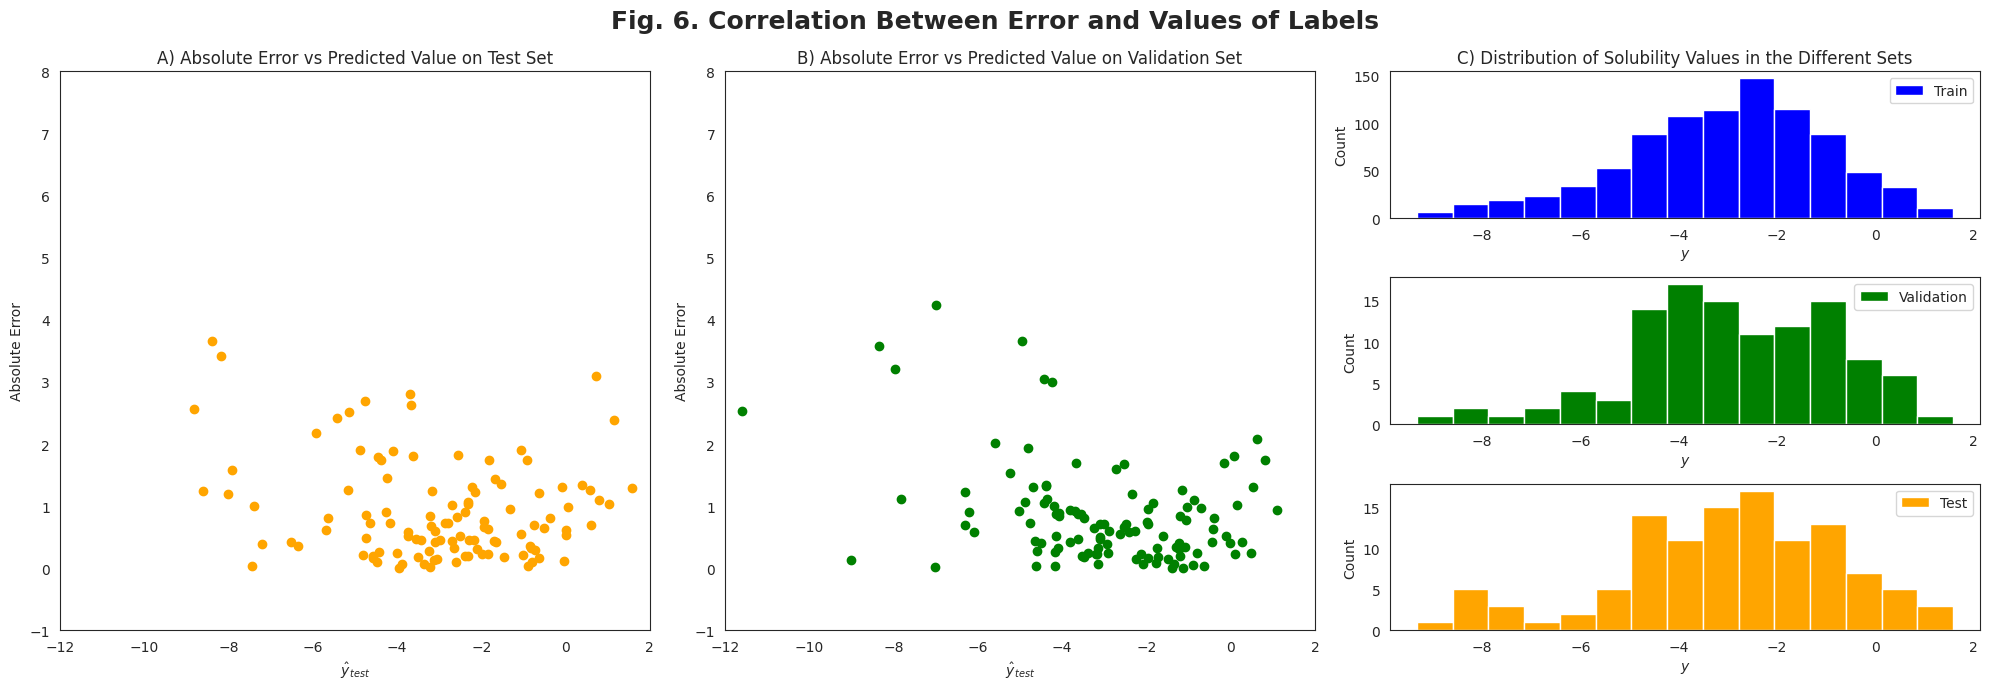

In [ ]:
makefig6()

#### **Evaluating The Impact of random Train/test/validation-splitting on the model performance**
In **Fig. 6** we saw that the distribution for solubility values in the test and validation set seemed reasonably similar to the one in the train set. This might not always be the case. We can try to redo the splitting X-amount of times and see how much the models error fluctuates as a consequence.

100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


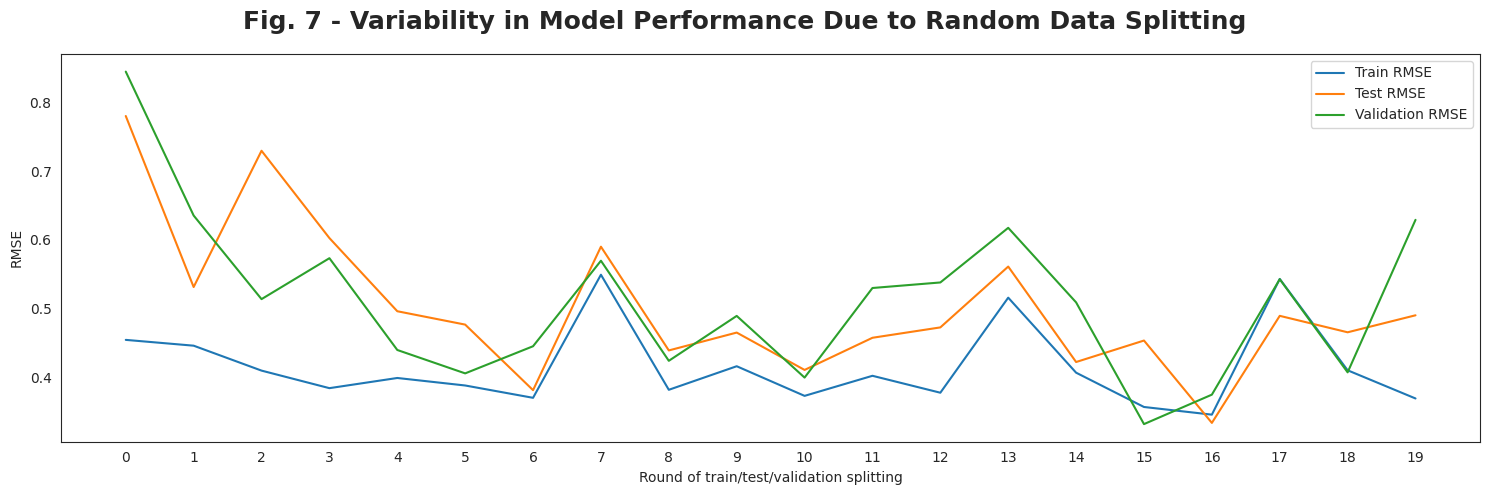

In [ ]:
makefig7()

What we see in **Fig. 7** is that the train RMSE is pretty consistent. This makes sense because this is our 'biggest' set, constituted of 80% of the data so it's likely to get a good span of different types of molecules. The RMSE on the train and test sets is way more varying. We see that we in some cases get a validation RMSE as high as 1, and in other cases as low as 0.4 (ish). The same goes for the test set. We can imagine that there is some probability that a lot of 'weird' molecules that are not very similar to the rest in the training set, will end up in the validation set. And in that case the model will predict badly on those and we get a large RMSE. In other cases we might get only molecules that are well represented in the trainigns et, that the model can easily make a good prediction on, and get a very low RMSE. But in the last case, that would also give us a false idea that the model is performing very well, when it's simply due to how the data was split.

#### **Is the model better if trained on count fingerprints?**
Earlier we saw that the some molecules get the same fingerprint even though their structures are different. By using count-fingerprints we can make the fingerprints take into account not only the presence of specific fragment, but also how many of them there are. It is obviously bad for our model if we try to force it to predict different labels on the same features. So if we train the model with the exact same parameters, but this time with count-fingerprints, we should not get any two different molecules that share a fingerprint. And then we should be able to see how much of a difference the way of featurizing the molecules makes.

This will be a bit more tricky-code wise because the count fingerprints can not simply be converted to numpy array by using np.array() on it. Instead we have to use rdkits own DataStructs.ConvertToNumpyArray() method.

##### **Code for Creating Count FIngeprints and Running Model Again**

In [ ]:
def conv_count_fp_to_arr(count_fp):
  arr = np.zeros((0,), dtype=np.int8)             # zero-array to populate
  DataStructs.ConvertToNumpyArray(count_fp, arr)  # populate array with count_fp
  return arr

X_train_c = np.array([conv_count_fp_to_arr(morgan_fp_gen.GetCountFingerprint(Chem.MolFromSmiles(smi))) for smi in train.smiles])
X_test_c = np.array([conv_count_fp_to_arr(morgan_fp_gen.GetCountFingerprint(Chem.MolFromSmiles(smi))) for smi in test.smiles])
X_val_c = np.array([conv_count_fp_to_arr(morgan_fp_gen.GetCountFingerprint(Chem.MolFromSmiles(smi))) for smi in val.smiles])

In [ ]:
count_hist = model.fit(
        X_train_c,
        y_train,
        validation_data=(X_val_c, y_val),
        epochs=100,
        batch_size=64,
        callbacks = [early_stop],
        verbose = 0
)

In [ ]:
test_predictions_c = model.predict(X_test_c)
val_predictions_c = model.predict(X_val_c)
train_predictions_c = model.predict(X_train_c)

29/29 [==============================] - 0s 2ms/step


##### **Metrics for the model - now trained on count-fingerprints**

In Fig. 7 I've plotted the same metrics as i Fig. 1, but this time the model has been trained on the count fingerprints. We see that the RMSE is lower, both on the training, test and validation set. This seems to indicate that our previous problem with different molecules having the same fingerprint actually did have a pretty detrimental effect on our model. And notably we can see in the predictions made on the training set that we no longer have the horizontal line of identical predicted values, that was very apparent in **Fig. 2**!

4/4 [==============================] - 0s 3ms/step


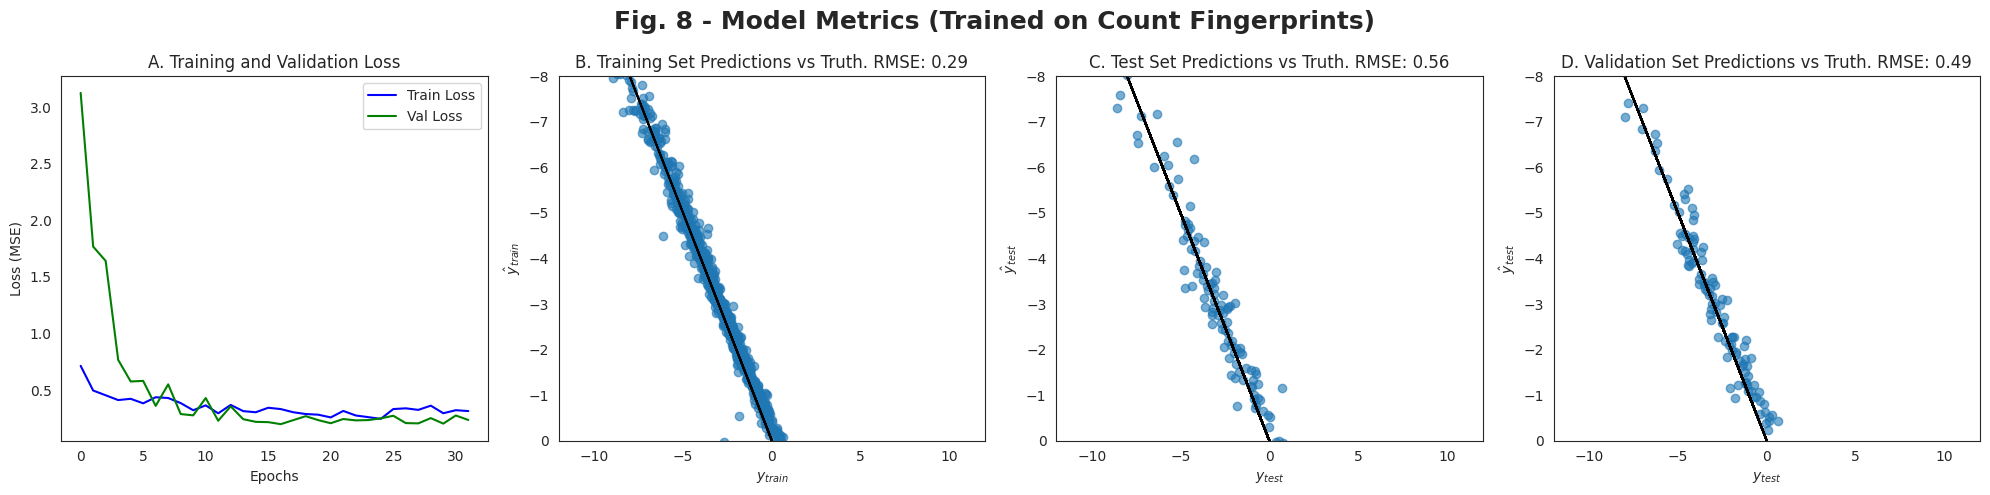

In [ ]:
plot_model_metrics(X_train_c, X_test_c, X_val_c, y_train, y_test, y_val, model = model, hist = count_hist, title = "Fig. 8 - Model Metrics (Trained on Count Fingerprints)")